In [9]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

pd.set_option('display.max_columns', None)

sys.path.append('./../')
import config
from utils import tools

In [2]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman'] 
mpl.rcParams['text.usetex'] = False

In [3]:
class DataProcessor:
    def __init__(self):
        self.dos_csv_path = config.DOS_CSV_PATH
        self.supercon_csv_path = config.SUPERCON_CSV_PATH

    def read_supercon_database(self):
        self.supercon_data = pd.read_csv(self.supercon_csv_path, skiprows=1)
        self.supercon_data.columns = ['chemical_formula', 'critical_temperature_k', 'ICSD', 'synth_doped']
        self.supercon_data['ICSD'] = self.supercon_data['ICSD'].str.replace('ICSD-', '')

    def read_materials_csv(self):
        self.materials_data = pd.read_csv(self.dos_csv_path)
        self.ICSD_preprocessor()
        self.identify_superconductors()

    def ICSD_preprocessor(self):
        self.materials_data['ICSD'] = pd.to_numeric(self.materials_data['ICSD'], errors='coerce').astype('Int64')
        num_nulos = self.materials_data['ICSD'].isnull().sum()
        len_df_pre = len(self.materials_data)
        print(f"{num_nulos} rows ({num_nulos/len_df_pre*100:.4f} %) where dropped because of null on ICSD.")
        self.materials_data.dropna(subset=['ICSD'], inplace=True)

    def identify_superconductors(self):
        ICSD_supercon = self.supercon_data.ICSD.unique().astype(int).tolist()
        self.materials_data.insert(5, 'is_superconductor', self.materials_data.ICSD.isin(ICSD_supercon))

    def processor(self):
        self.read_supercon_database()
        self.read_materials_csv()
        return self.materials_data, self.supercon_data


MaterialsProcessor = DataProcessor()
materials_data, supercon_data = MaterialsProcessor.processor()

C:\Users\olaya\AppData\Local\Temp\ipykernel_27656\2883198947.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  self.materials_data = pd.read_csv(self.dos_csv_path)


1 rows (0.0017 %) where dropped because of null on ICSD.


2024-06-10 00:19:49: · MODULE: Plotter...


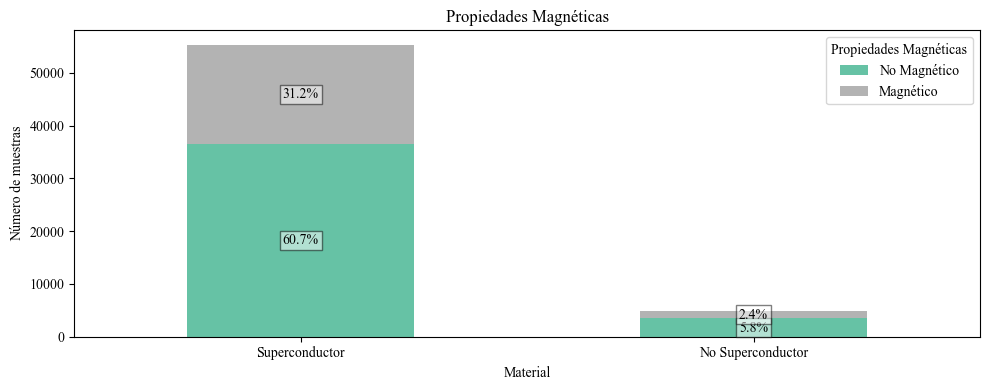

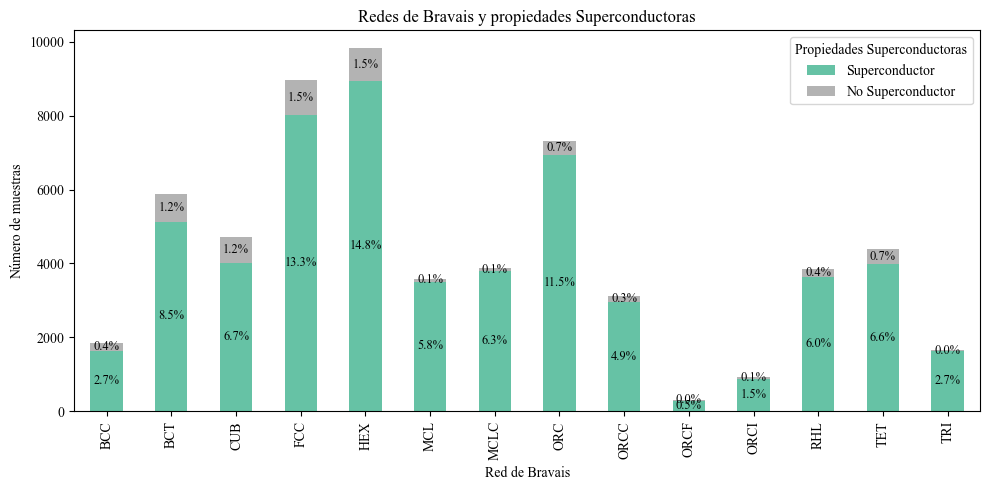

In [45]:
class Plotter:

    def __init__(self, materials_data, run_results_path):
        self.materials_data = materials_data
        self.run_results_path = run_results_path
        tools.log_main('· MODULE: Plotter...', save_path=self.run_results_path)

    def _calculate_stats(self, column_name):
        """Calculates and returns statistics for a given column."""
        value_counts = self.materials_data[column_name].value_counts()
        total_count = len(self.materials_data[column_name])
        true_count = value_counts.get(True, 0)
        true_percentage = (true_count / total_count) * 100
        return true_percentage, total_count, true_count

    def superconductors_stats(self):
        """Calculates and writes superconductor statistics to a report file."""
        true_percentage, total_count, true_count = self._calculate_stats('is_superconductor')
        with open(os.path.join(self.run_results_path, 'stats_report.txt'), 'a') as f:
            f.write(f"Percentage of superconductors: {true_percentage:.2f}%\n")
            f.write(f'Total materials: {total_count}\n')
            f.write(f'Superconducting materials: {true_count}\n')

    def magnetic_stats(self):
        """Calculates and writes magnetic statistics to a report file."""
        true_percentage, total_count, true_count = self._calculate_stats('is_magnetic')
        with open(os.path.join(self.run_results_path, 'stats_report.txt'), 'a') as f:
            f.write(f"Percentage of magnetic: {true_percentage:.2f}%\n")
            f.write(f'Total materials: {total_count}\n')
            f.write(f'Magnetic materials: {true_count}\n')

    def stats_report(self):
        """Writes the complete statistics report to a file."""
        report_file = os.path.join(self.run_results_path, 'stats_report.txt')
        if not os.path.exists(report_file):
            with open(report_file, 'w') as f:
                f.write(f'···················· STATISTICS ····················\n')
        self.superconductors_stats()
        with open(report_file, 'a') as f:
            f.write(f'····················································\n')
        self.magnetic_stats()
        with open(report_file, 'a') as f:
            f.write(f'····················································\n')
        
    def magnetic_properties_plot(self):
        grouped_data = self.materials_data.groupby(['is_superconductor', 'is_magnetic']).size()
        ax = grouped_data.unstack().plot(kind='bar', stacked=True, colormap='Set2', figsize=(10,4))
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            ax.text(x + width/2,
                    y + height/2,
                    '{:.1f}%'.format(height/grouped_data.sum() * 100),
                    ha='center', va='center',
                    fontsize=10, color='black',
                    bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2})
        plt.title('Propiedades Magnéticas')
        plt.xlabel('Material')
        plt.ylabel('Número de muestras')
        plt.xticks([0, 1], ['Superconductor', 'No Superconductor'], rotation=0)
        plt.legend(title='Propiedades Magnéticas', labels=['No Magnético', 'Magnético'])
        plt.tight_layout()
        tools.save_plot(self.run_results_path, 'magnetic_properties')
        plt.show()

    def supercon_properties_by_bravais_plot(self):
        grouped_data = self.materials_data.groupby(['bravais_lattice', 'is_superconductor']).size()
        unstacked_data = grouped_data.unstack(fill_value=0)
        
        ax = unstacked_data.plot(kind='bar', stacked=True, colormap='Set2', figsize=(10, 5))
        total_samples = len(self.materials_data)
        for container in ax.containers:
            for rect in container:
                height = rect.get_height()
                percentage = 100 * height / total_samples
                if height > 0:  # Mostrar sólo si la altura es mayor a 0
                    ax.annotate(f'{percentage:.1f}%', 
                                xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2), 
                                ha='center', va='center', fontsize=9, color='black')
        
        plt.title('Redes de Bravais y propiedades Superconductoras')
        plt.xlabel('Red de Bravais')
        plt.ylabel('Número de muestras')
        plt.legend(title='Propiedades Superconductoras', labels=['Superconductor', 'No Superconductor'])
        plt.tight_layout()
        tools.save_plot(self.run_results_path, 'superconducting_properties_by_bravais_lattice')
        plt.show()
    
    def workflow(self):
        self.stats_report()
        self.magnetic_properties_plot()
        self.supercon_properties_by_bravais_plot()


plotter = Plotter(materials_data, config.PATH_TEST_FIGURES)
plotter.workflow()
